<h1 style="font-size:400%">FRUIT DETECTOR</h1>

This notebook is a demonstration of using [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained model for object detection to detect fruits. The data for this example is included in the git repo, so you can just clone this repo and run the notebook.

![banner](https://raw.githubusercontent.com/bshtmichielsen/fruit_detector/refs/heads/main/BANNER.jpg)
*Image by Stable Diffusion: a machine detecting different types of fruit*

In [1]:
import os, pandas, PIL, platform, random, torch, xml

import torchvision as V
import torch.utils.data as D
import lightning as L
import torchmetrics as M

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

data_path = "dataset/data"
test_data_path = "dataset/test"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", V.__version__, "| lightning", L.__version__)

Versions: python 3.14.2 | torch 2.9.1+cu130 | torchvision 0.24.1+cu130 | lightning 2.6.0


# Loading a pre-trained model


In [2]:
pretrained_model = V.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")

img_size = (pretrained_model.transform.min_size[0], pretrained_model.transform.min_size[0])

print("Input image size defined as", img_size)

Input image size defined as (320, 320)


# Prepare the dataset



In [3]:
class ObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, path, image_size):
        self.path = path
        self.image_size = image_size
        self.annotations = [f for f in os.listdir(path) if f.endswith(".xml")]
        names = list(set([o.find("name").text 
            for a in self.annotations 
            for o in xml.etree.ElementTree.parse(os.path.join(self.path, a)).getroot().findall("object")]))
        names.sort()
        self.classes = ["__background__"] + names

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image = PIL.Image.open(os.path.join(self.path, self.annotations[index].replace(".xml", ".jpg"))).convert("RGB")
        w, h = image.size
        x_scale, y_scale = self.image_size[0] / w, self.image_size[1] / h
        image = V.transforms.Compose([
            V.transforms.Resize(self.image_size),
            V.transforms.ToTensor(),
        ])(image)
        labels, boxes = [], []
        for obj in xml.etree.ElementTree.parse(os.path.join(self.path, self.annotations[index])).getroot().findall("object"):
            labels.append(self.classes.index(obj.find("name").text))
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) * x_scale
            ymin = int(bbox.find("ymin").text) * y_scale
            xmax = int(bbox.find("xmax").text) * x_scale
            ymax = int(bbox.find("ymax").text) * y_scale
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)
        return image, {"boxes": boxes, "labels": labels}


dataset = ObjectDetectionDataset(data_path, image_size=img_size)
testset = ObjectDetectionDataset(test_data_path, image_size=img_size)
print("Created a dataset with", len(dataset), "images of size", dataset.image_size, "and the following classes:", dataset.classes)
print("Created a testset with", len(testset), "images of size", testset.image_size, "and the following classes:", testset.classes)

Created a dataset with 275 images of size (320, 320) and the following classes: ['__background__', 'apple', 'banana', 'orange']
Created a testset with 24 images of size (320, 320) and the following classes: ['__background__', 'apple', 'banana', 'orange']


# Sample the data

This is just a random sample of images and their labels. 

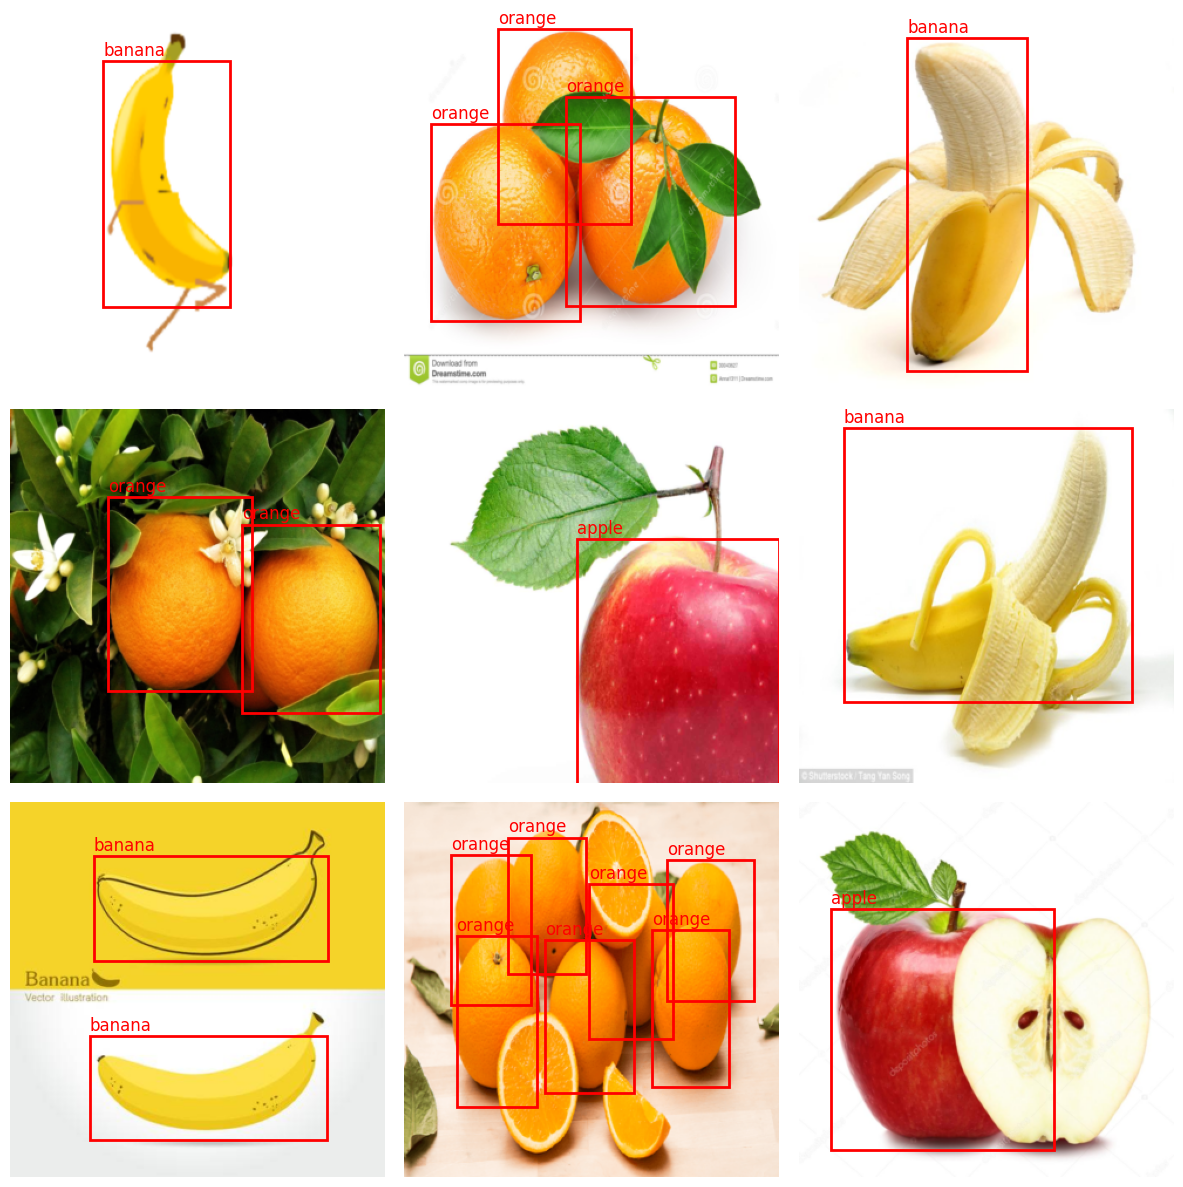

In [4]:
num_images = 9
indices = random.sample(range(len(dataset)), num_images)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for ax, index in zip(axes, indices):
    image, target = dataset[index]
    ax.imshow(V.transforms.ToPILImage()(image))
    ax.axis("off")
    for box, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()], color='red', fontsize=12)
plt.tight_layout()

## Create a data module

Here we extend the LightningDataModule create a DataModule that splits the dataset into train and val data. Given that we loaded the test data from a seprate location we do not need to split it from the dataset and can just provide it as is.

In [20]:
def collate(batch):
    return tuple(zip(*batch))

class DataModule(L.LightningDataModule):
    def __init__(self, data, test_data, split=[.7, .3], batch_size=32, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.test = test_data
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        torch.manual_seed(0)
        self.train, self.val = D.random_split(self.data, self.split)

    def train_dataloader(self):
        return D.DataLoader(self.train, shuffle=True, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)
    
    def val_dataloader(self):
        return D.DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)
    
    def test_dataloader(self):
        return D.DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate, num_workers=self.num_workers, persistent_workers=False)

datamodule = DataModule(dataset, testset)
datamodule.setup()
print("Created a datamodule with", len(datamodule.train_dataloader().dataset), "train images,", len(datamodule.val_dataloader().dataset), "validation images and", len(datamodule.test_dataloader().dataset), "test images.")

Created a datamodule with 193 train images, 82 validation images and 24 test images.


## Create the model

A LightningModule is extended to load the pretrained model that we downloaded before, and allow it to be fine-tuned.

In [21]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class ObjectDetectionModel(L.LightningModule):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        self.mAP = M.detection.mean_ap.MeanAveragePrecision(box_format="xyxy", iou_type="bbox", class_metrics=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_mAP"}
        
    def forward(self, x, targets=None):
        return self.model(x, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self(images, targets)
        return sum(loss for loss in loss_dict.values())

    def validation_step(self, batch):
        images, targets = batch
        predictions = self.model(images)
        self.mAP(preds=predictions, target=targets)

    def on_validation_epoch_end(self):
        mAP_score = self.mAP.compute()
        self.log("val_mAP", mAP_score["map"])
        self.mAP.reset()
    
    def test_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.model(images)
        self.mAP(preds=predictions, target=targets)

    def on_test_epoch_end(self):
        mAP_score = self.mAP.compute()
        for i in range(self.num_classes -1):
            self.log("test_mAP_class_" + str(i+1), mAP_score["map_per_class"][i])
        self.mAP.reset()
    
    def predict_step(self, batch):
        x, y = batch
        return self.model(x)

model = ObjectDetectionModel(pretrained_model, num_classes=len(dataset.classes))

# Train

Now, let's use the PyTorch Lightning Trainer to train the model with our Data Module. Rather than telling it beforehand how many epochs to train, we use an EarlyStopping callback that stops the training process when the model has reached convergence. Information is logged to a CSV logger that can be used after training to provide evaluation metrics.

In [22]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_mAP", mode="max", patience=5)
trainer = L.Trainer(max_epochs=-1, logger=logger, callbacks=[stop], log_every_n_steps=7)
trainer.fit(model, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model | FasterRCNN           | 18.9 M | train | 0    
1 | mAP   | MeanAveragePrecision | 0      | train | 0    
---------------------------------------------------------------
18.9 M    Trainable params
58.9 K    Non-trainable params
18.9 M    Total params
75.762    Total estimated model params size (MB)
281       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 17: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s, v_num=22]


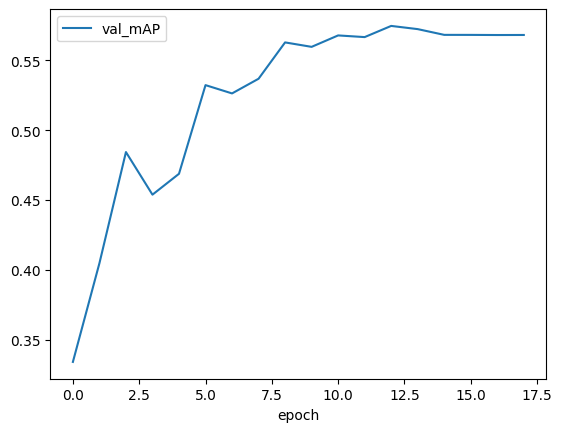

In [23]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_mAP"]].set_index("epoch")
plot = loss_metrics.plot()

## Test

Here we use the Trainer to run the model against the test data and collect the evaluation metrics.

In [24]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
mAPs = [scores[0]["test_mAP_class_" + str(i+1)] for i in range(len(dataset.classes)-1)]
df = pandas.DataFrame({"class": dataset.classes[1:], "mAP": mAPs}).set_index("class")
df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


mAP
class           
apple   0.705488
banana  0.358416
orange  0.673376

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


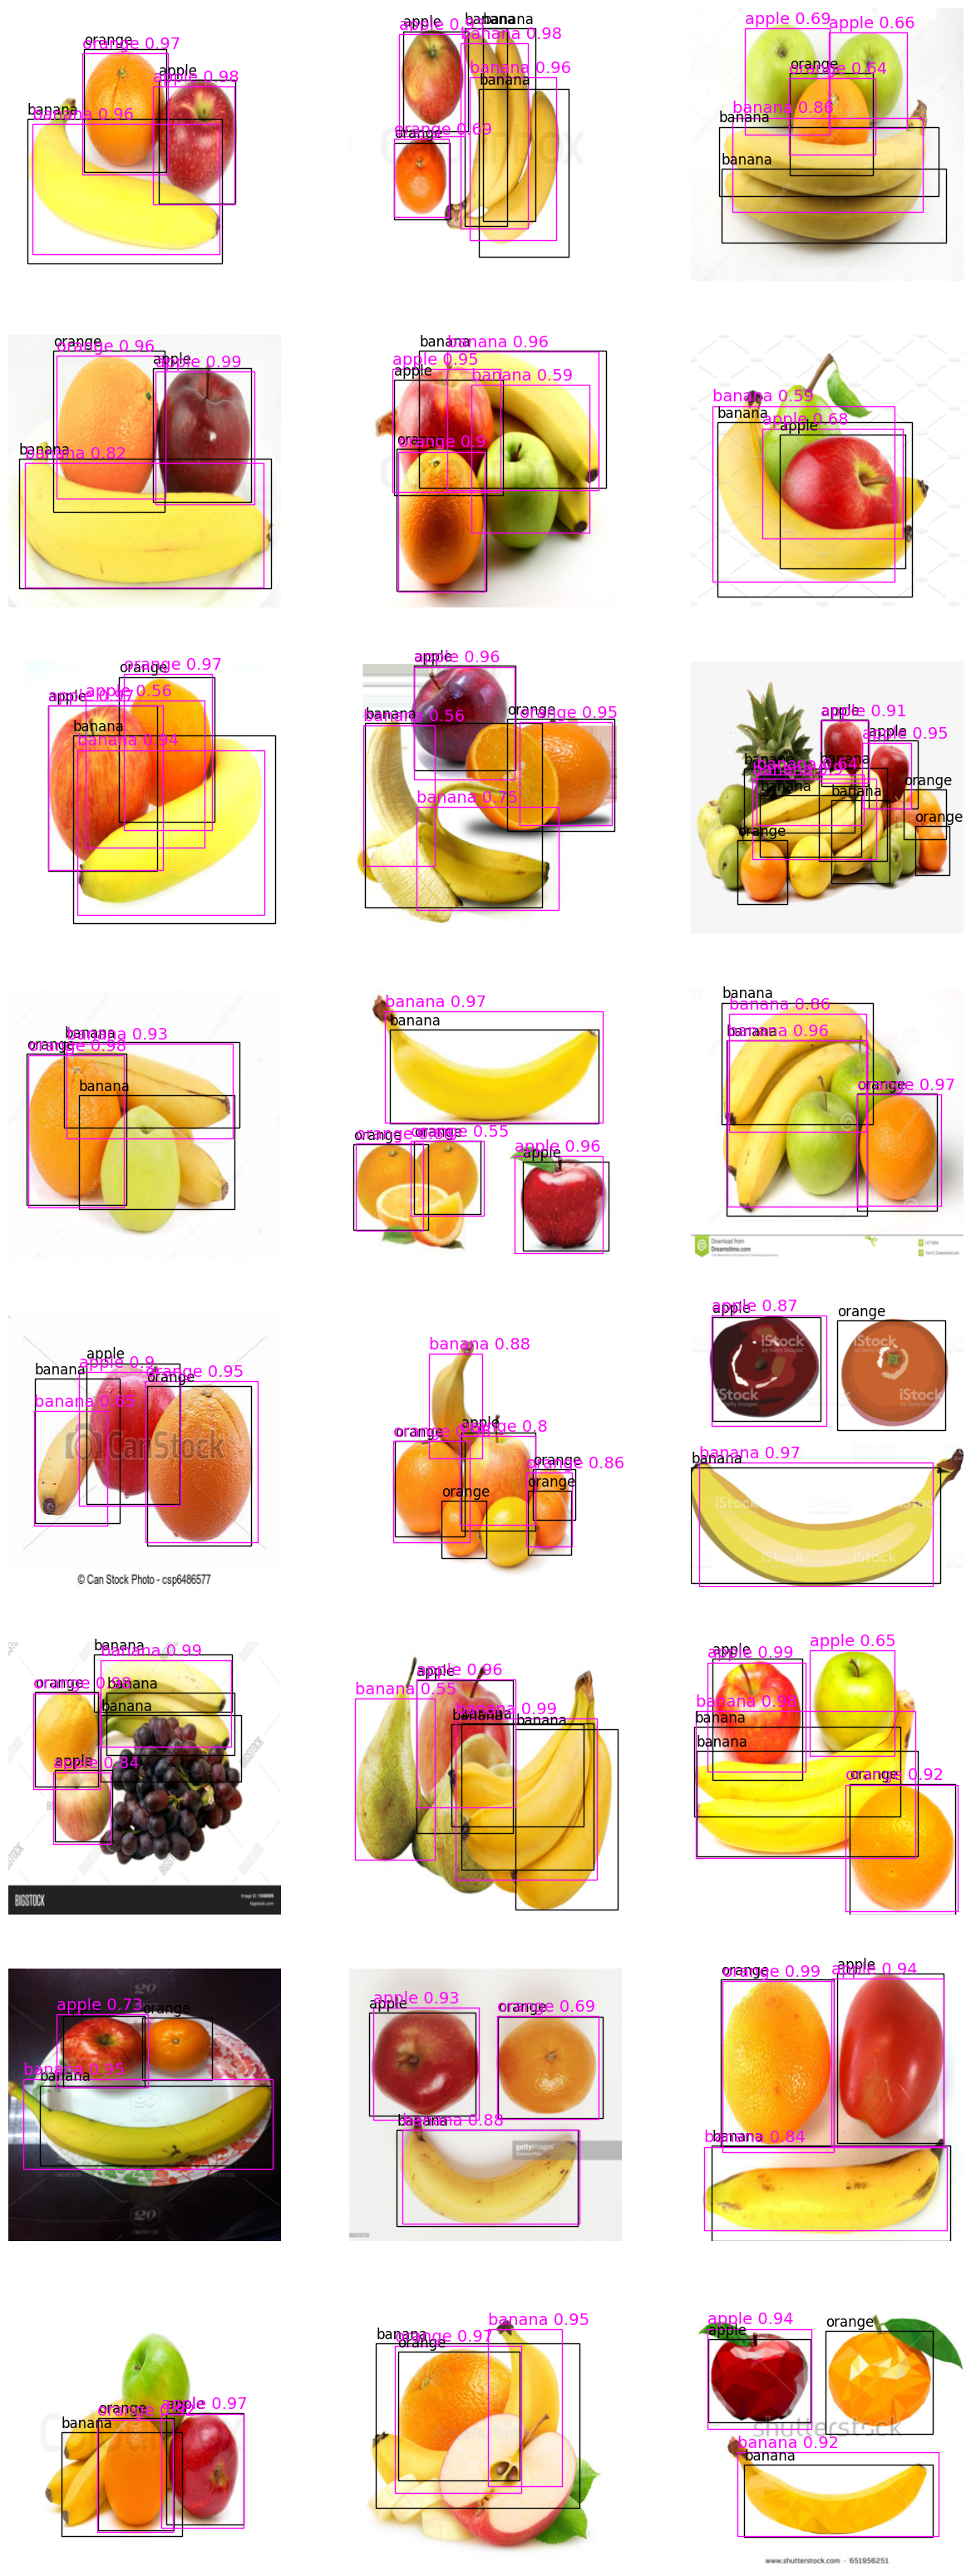

In [25]:
dataloader = datamodule.test_dataloader()
preds = trainer.predict(model, dataloaders=dataloader)

images = [d[0] for _, d in enumerate(dataloader.dataset)]
targets = [d[1] for _, d in enumerate(dataloader.dataset)]

threshold = .5

fig, axes = plt.subplots(8, 3, figsize=(15, 40))
axes = axes.flatten()
for ax, image, prediction, target in zip(axes, images, preds[0], targets):
    ax.imshow(V.transforms.ToPILImage()(image))
    ax.axis("off")
    for truth, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = truth[0], truth[1], truth[2], truth[3]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='black', linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()], color='black', fontsize=12)
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score < threshold:
            continue
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='fuchsia', linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, dataset.classes[label.item()] + " " + str(round(score.item(),2)), color='fuchsia', fontsize=14)
